In [1]:
# install torch fidelity for FID, ISC score 
# https://github.com/toshas/torch-fidelity
# https://torch-fidelity.readthedocs.io/en/latest/precision.html

In [2]:
!nvidia-smi

Sun Dec 26 06:45:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install dalle-pytorch --upgrade

### Restart runtime from here

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [6]:
from __future__ import print_function
import random
import torch.nn.parallel
import numpy as np
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [7]:
from easydict import EasyDict

# constants

VAE_CFG = EasyDict()

VAE_CFG.IMAGE_SIZE = 256
VAE_CFG.IMAGE_PATH = './'

VAE_CFG.BASELINE = False

In [8]:
from random import choice
from pathlib import Path

# torch

import torch
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_

# vision imports

from PIL import Image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image

# dalle related classes and utils

from dalle_pytorch import OpenAIDiscreteVAE, DiscreteVAE, DALLE

# helpers

def exists(val):
    return val is not None

In [9]:
import shutil

vqgan_best_path = "/content/drive/MyDrive/K-Fashion/VQGAN Models/VQGAN_blue_e7"
shutil.copy(vqgan_best_path, "./")

vqgan_best_yaml_path = "/content/drive/MyDrive/K-Fashion/VQGAN Models/VQGAN_blue.yaml"
shutil.copy(vqgan_best_yaml_path, "./")

'./VQGAN_blue.yaml'

In [10]:
dalle_best_path = "/content/drive/MyDrive/K-Fashion/DALLE Models/dalle_vq_blue_e7_final.pt"
shutil.copy(dalle_best_path, "./")

'./dalle_vq_blue_e7_final.pt'

In [11]:
from easydict import EasyDict
import os

DALLE_CFG = EasyDict()

# argument parsing

# DALLE_CFG.VQGAN_PATH = "/Users/noopy/Documents/DALLE-Couture/models/last_51485_step.ckpt"   # './vae.pt' - will use OpenAIs pretrained VAE if not set
DALLE_CFG.VQGAN_PATH = os.path.basename(vqgan_best_path)
# DALLE_CFG.VQGAN_CFG_PATH = "/Users/noopy/Documents/DALLE-Couture/models/2021-12-15T16-24-36-project.yaml"   # './vae.pt' - will use OpenAIs pretrained VAE if not set
DALLE_CFG.VQGAN_CFG_PATH = os.path.basename(vqgan_best_yaml_path)
DALLE_CFG.DALLE_PATH = os.path.basename(dalle_best_path)   # './vae.pt' - will use OpenAIs pretrained VAE if not set
DALLE_CFG.TAMING = True    # use VAE from taming transformers paper
DALLE_CFG.IMAGE_TEXT_FOLDER = './'
DALLE_CFG.BPE_PATH = None
DALLE_CFG.RESUME = os.path.exists(DALLE_CFG.DALLE_PATH)

# DALLE_CFG.EPOCHS = 20
# DALLE_CFG.BATCH_SIZE = 54
DALLE_CFG.LEARNING_RATE = 3e-4
DALLE_CFG.GRAD_CLIP_NORM = 0.5

# DALLE_CFG.MODEL_DIM = 512
DALLE_CFG.TEXT_SEQ_LEN = 128
DALLE_CFG.DEPTH = 2
DALLE_CFG.HEADS = 8
DALLE_CFG.DIM_HEAD = 64
DALLE_CFG.REVERSIBLE = True

In [12]:
DALLE_CFG.RESUME

True

In [13]:
# import from huggingface transformers
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
# model = AutoModelWithLMHead.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5")

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [14]:
!nvidia-smi

Sun Dec 26 06:47:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
from dalle_pytorch import VQGanVAE
from pathlib import Path

DALLE_CFG.VOCAB_SIZE = tokenizer.vocab_size # refer to EDA, there are only 333 words total. but input_ids index should be in within 0 ~ 52000: https://github.com/boostcampaitech2-happyface/DALLE-Couture/blob/pytorch-dalle/EDA.ipynb

dalle_path = Path(DALLE_CFG.DALLE_PATH)
assert dalle_path.exists(), 'DALL-E model file does not exist'

loaded_obj = torch.load(str(dalle_path), map_location=torch.device('cuda:0'))

dalle_params, vae_params, weights = loaded_obj['hparams'], loaded_obj['vae_params'], loaded_obj['weights']

vae_klass = VQGanVAE
vae = vae_klass(
    vqgan_model_path=DALLE_CFG.VQGAN_PATH, 
    vqgan_config_path=DALLE_CFG.VQGAN_CFG_PATH
    )

DALLE_CFG.IMAGE_SIZE = vae.image_size

dalle_params = dict(        
    **dalle_params
)

DALLE_CFG.IMAGE_SIZE = vae.image_size

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 79.8kB/s]


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from VQGAN_blue_e7 and VQGAN_blue.yaml


In [16]:
dalle_params

{'attn_dropout': 0,
 'attn_types': ('full',),
 'depth': 16,
 'dim_head': 64,
 'ff_dropout': 0,
 'heads': 8,
 'loss_img_weight': 7,
 'num_text_tokens': 32000,
 'reversible': False,
 'rotary_emb': False,
 'shift_tokens': False,
 'stable': False,
 'text_seq_len': 128}

In [17]:
from math import log2, sqrt
import torch
from torch import nn, einsum
import torch.nn.functional as F
import numpy as np

from axial_positional_embedding import AxialPositionalEmbedding
from einops import rearrange

from dalle_pytorch import distributed_utils
from dalle_pytorch.vae import OpenAIDiscreteVAE, VQGanVAE
from dalle_pytorch.transformer import Transformer, DivideMax
from dalle_pytorch.attention import stable_softmax

In [18]:
def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


class always:
    def __init__(self, val):
        self.val = val

    def __call__(self, x, *args, **kwargs):
        return self.val


def is_empty(t):
    return t.nelement() == 0


def masked_mean(t, mask, dim=1):
    t = t.masked_fill(~mask[:, :, None], 0.0)
    return t.sum(dim=1) / mask.sum(dim=1)[..., None]


def set_requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value


def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        was_training = model.training
        model.eval()
        out = fn(model, *args, **kwargs)
        model.train(was_training)
        return out

    return inner


# sampling helpers


def top_k(logits, thres=0.5):
    num_logits = logits.shape[-1]
    k = max(int((1 - thres) * num_logits), 1)
    val, ind = torch.topk(logits, k)
    probs = torch.full_like(logits, float("-inf"))
    probs.scatter_(1, ind, val)
    return probs


# discrete vae class


class ResBlock(nn.Module):
    def __init__(self, chan):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(chan, chan, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(chan, chan, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(chan, chan, 1),
        )

    def forward(self, x):
        return self.net(x) + x



In [19]:
class DALLE_Klue_Roberta(nn.Module):
    def __init__(
        self,
        *,
        # dim,
        vae,
        num_text_tokens=10000,
        text_seq_len=256,
        depth,
        heads=8,
        dim_head=64,
        reversible=False,
        attn_dropout=0.0,
        ff_dropout=0,
        sparse_attn=False,
        attn_types=None,
        loss_img_weight=7,
        stable=False,
        sandwich_norm=False,
        shift_tokens=True,
        rotary_emb=False,
        wte_dir=None,
        wpe_dir=None,
    ):
        super().__init__()
        assert isinstance(
            vae, (DiscreteVAE, OpenAIDiscreteVAE, VQGanVAE)
        ), "vae must be an instance of DiscreteVAE"
        image_size = vae.image_size
        num_image_tokens = vae.num_tokens
        image_fmap_size = vae.image_size // (2 ** vae.num_layers)
        image_seq_len = image_fmap_size ** 2

        num_text_tokens = (
            num_text_tokens + text_seq_len
        )  # reserve unique padding tokens for each position (text seq len)

        self.text_emb = torch.load(wte_dir)
        dim = self.text_emb.weight.shape[1]
        self.image_emb = nn.Embedding(num_image_tokens, dim)
        print(dim,image_fmap_size,image_fmap_size)
        self.text_pos_emb = torch.load(wpe_dir) if not rotary_emb else always(0)  # +1 for <bos>
        self.image_pos_emb = (
            AxialPositionalEmbedding(dim, axial_shape=(image_fmap_size, image_fmap_size))
            if not rotary_emb
            else always(0)
        )

        self.num_text_tokens = (
            num_text_tokens  # for offsetting logits index and calculating cross entropy loss
        )
        self.num_image_tokens = num_image_tokens

        self.text_seq_len = text_seq_len
        self.image_seq_len = image_seq_len

        seq_len = text_seq_len + image_seq_len
        total_tokens = num_text_tokens + num_image_tokens
        self.total_tokens = total_tokens
        self.total_seq_len = seq_len

        self.vae = vae
        set_requires_grad(self.vae, False)  # freeze VAE from being trained

        self.transformer = Transformer(
            dim=dim,
            causal=True,
            seq_len=seq_len,
            depth=depth,
            heads=heads,
            dim_head=dim_head,
            reversible=reversible,
            attn_dropout=attn_dropout,
            ff_dropout=ff_dropout,
            attn_types=attn_types,
            image_fmap_size=image_fmap_size,
            sparse_attn=sparse_attn,
            stable=stable,
            sandwich_norm=sandwich_norm,
            shift_tokens=shift_tokens,
            rotary_emb=rotary_emb,
        )

        self.stable = stable

        if stable:
            self.norm_by_max = DivideMax(dim=-1)

        self.to_logits = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, self.total_tokens),
        )

        seq_range = torch.arange(seq_len)
        logits_range = torch.arange(total_tokens)

        seq_range = rearrange(seq_range, "n -> () n ()")
        logits_range = rearrange(logits_range, "d -> () () d")

        logits_mask = ((seq_range >= text_seq_len) & (logits_range < num_text_tokens)) | (
            (seq_range < text_seq_len) & (logits_range >= num_text_tokens)
        )

        self.register_buffer("logits_mask", logits_mask, persistent=False)
        self.loss_img_weight = loss_img_weight

    @torch.no_grad()
    @eval_decorator
    def generate_texts(self, tokenizer, text=None, *, filter_thres=0.5, temperature=1.0):
        text_seq_len = self.text_seq_len
        if text is None or text == "":
            text_tokens = torch.tensor([[0]]).cuda()
        else:
            text_tokens = torch.tensor(tokenizer.tokenizer.encode(text)).cuda().unsqueeze(0)

        for _ in range(text_tokens.shape[1], text_seq_len):
            device = text_tokens.device

            tokens = self.text_emb(text_tokens)
            tokens += self.text_pos_emb(torch.arange(text_tokens.shape[1], device=device))

            seq_len = tokens.shape[1]

            output_transf = self.transformer(tokens)

            if self.stable:
                output_transf = self.norm_by_max(output_transf)

            logits = self.to_logits(output_transf)

            # mask logits to make sure text predicts text (except last token), and image predicts image

            logits_mask = self.logits_mask[:, :seq_len]
            max_neg_value = -torch.finfo(logits.dtype).max
            logits.masked_fill_(logits_mask, max_neg_value)
            logits = logits[:, -1, :]

            filtered_logits = top_k(logits, thres=filter_thres)
            probs = stable_softmax(filtered_logits / temperature, dim=-1)
            sample = torch.multinomial(probs, 1)

            text_tokens = torch.cat((text_tokens, sample), dim=-1)

        padding_tokens = set(
            np.arange(self.text_seq_len) + (self.num_text_tokens - self.text_seq_len)
        )
        texts = [
            tokenizer.tokenizer.decode(text_token, pad_tokens=padding_tokens)
            for text_token in text_tokens
        ]
        return text_tokens, texts

    @torch.no_grad()
    @eval_decorator
    def generate_images(
        self,
        text,
        *,
        clip=None,
        mask=None,
        filter_thres=0.5,
        temperature=1.0,
        img=None,
        num_init_img_tokens=None,
    ):
        vae, text_seq_len, image_seq_len, num_text_tokens = (
            self.vae,
            self.text_seq_len,
            self.image_seq_len,
            self.num_text_tokens,
        )
        total_len = text_seq_len + image_seq_len

        text = text[:, :text_seq_len]  # make sure text is within bounds
        out = text

        if exists(img):
            image_size = vae.image_size
            assert (
                img.shape[1] == 3 and img.shape[2] == image_size and img.shape[3] == image_size
            ), f"input image must have the correct image size {image_size}"

            indices = vae.get_codebook_indices(img)
            num_img_tokens = default(
                num_init_img_tokens, int(0.4375 * image_seq_len)
            )  # OpenAI used 14 * 32 initial tokens to prime
            assert (
                num_img_tokens < image_seq_len
            ), "number of initial image tokens for priming must be less than the total image token sequence length"

            indices = indices[:, :num_img_tokens]
            out = torch.cat((out, indices), dim=-1)

        for cur_len in range(out.shape[1], total_len):
            is_image = cur_len >= text_seq_len

            text, image = out[:, :text_seq_len], out[:, text_seq_len:]

            logits = self(text, image, mask=mask)[:, -1, :]

            filtered_logits = top_k(logits, thres=filter_thres)
            probs = F.softmax(filtered_logits / temperature, dim=-1)
            sample = torch.multinomial(probs, 1)

            sample -= (
                num_text_tokens if is_image else 0
            )  # offset sampled token if it is an image token, since logit space is composed of text and then image tokens
            out = torch.cat((out, sample), dim=-1)

            if out.shape[1] <= text_seq_len:
                mask = F.pad(mask, (0, 1), value=True)

        text_seq = out[:, :text_seq_len]

        img_seq = out[:, -image_seq_len:]
        images = vae.decode(img_seq)

        if exists(clip):
            scores = clip(text_seq, images, return_loss=False)
            return images, scores

        return images

    def forward(self, text, image=None, mask=None, return_loss=False):
        assert (
            text.shape[-1] == self.text_seq_len
        ), f"the length {text.shape[-1]} of the text tokens you passed in does not have the correct length ({self.text_seq_len})"
        device, total_seq_len = text.device, self.total_seq_len

        # make sure padding in text tokens get unique padding token id

        #text_range = torch.arange(self.text_seq_len, device=device) + (
        #    self.num_text_tokens - self.text_seq_len
        #)
        #print(torch.max(text))
        #print(text)
        #torch.save(text,'text.pt')
        #text = torch.where(text == 3, text_range, text)

        # add <bos>
        #print(text.shape)
        #print(text)
        #print(torch.max(text))
        text = F.pad(text, (1, 0), value=0)
        #print(text.shape)
        #print(text)
        #print(torch.max(text))
        tokens = self.text_emb(text)
        tokens += self.text_pos_emb(torch.arange(text.shape[1], device=device))

        seq_len = tokens.shape[1]

        if exists(image) and not is_empty(image):
            is_raw_image = len(image.shape) == 4

            if is_raw_image:
                image_size = self.vae.image_size
                assert tuple(image.shape[1:]) == (
                    3,
                    image_size,
                    image_size,
                ), f"invalid image of dimensions {image.shape} passed in during training"

                image = self.vae.get_codebook_indices(image)
            image_len = image.shape[1]
            image_emb = self.image_emb(image)
            image_emb += self.image_pos_emb(image_emb)

            tokens = torch.cat((tokens, image_emb), dim=1)

            seq_len += image_len

        # when training, if the length exceeds the total text + image length
        # remove the last token, since it needs not to be trained

        if tokens.shape[1] > total_seq_len:
            seq_len -= 1
            tokens = tokens[:, :-1]

        if self.stable:
            alpha = 0.1
            tokens = tokens * alpha + tokens.detach() * (1 - alpha)

        out = self.transformer(tokens)

        if self.stable:
            out = self.norm_by_max(out)

        logits = self.to_logits(out)

        # mask logits to make sure text predicts text (except last token), and image predicts image

        logits_mask = self.logits_mask[:, :seq_len]
        max_neg_value = -torch.finfo(logits.dtype).max
        logits.masked_fill_(logits_mask, max_neg_value)

        if not return_loss:
            return logits

        assert exists(image), "when training, image must be supplied"

        offsetted_image = image + self.num_text_tokens
        labels = torch.cat((text[:, 1:], offsetted_image), dim=1)

        logits = rearrange(logits, "b n c -> b c n")

        loss_text = F.cross_entropy(
            logits[:, :, : self.text_seq_len], labels[:, : self.text_seq_len]
        )
        loss_img = F.cross_entropy(
            logits[:, :, self.text_seq_len :], labels[:, self.text_seq_len :]
        )

        loss = (loss_text + self.loss_img_weight * loss_img) / (self.loss_img_weight + 1)
        return loss


In [20]:
import shutil

roberta_wte = "/content/drive/MyDrive/K-Fashion/Text-Encoders/roberta_large_wte.pt"
shutil.copy(roberta_wte, "./")

roberta_wpe = "/content/drive/MyDrive/K-Fashion/Text-Encoders/roberta_large_wpe.pt"
shutil.copy(roberta_wpe, "./")

ROBERTA_WTE_PATH = os.path.basename(roberta_wte)
ROBERTA_WPE_PATH = os.path.basename(roberta_wpe)

In [21]:
from google.colab import drive
drive.flush_and_unmount()

In [22]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
dalle = DALLE_Klue_Roberta(
    vae = vae, 
    wte_dir="./roberta_large_wte.pt",
    wpe_dir="./roberta_large_wpe.pt",
    **dalle_params
    ).to(device)

dalle.load_state_dict(weights)

1024 16 16


<All keys matched successfully>

In [27]:
%%time
input_text = \
"하의에서 색상은 오렌지이다. 하의에서 디테일에는 플리츠이다. 하의에서 소재에는 실크이다. \
하의에서 프린트에는 무지이다. 하의에서 핏은 노멀이다. \
상의에서 기장은 노멀이다. 상의에서 색상은 화이트이다. 상의에서 옷깃은 셔츠칼라이다. \
상의에서 디테일에는 레이스이다. 상의에서 소매기장은 긴팔이다. 상의에서 소재에는 우븐이다."

encoded_dict = tokenizer(
    input_text,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=DALLE_CFG.TEXT_SEQ_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,  # for RoBERTa
)
input_ids = encoded_dict["input_ids"].to(device)
attention_mask = encoded_dict["attention_mask"].to(device)

# https://github.com/lucidrains/DALLE-pytorch/blob/main/dalle_pytorch/dalle_pytorch.py#L454-L510
# 12 minutes for K11
images = dalle.generate_images(input_ids, mask = attention_mask)
images.shape # (4, 3, 256, 256)

CPU times: user 8.51 s, sys: 0 ns, total: 8.51 s
Wall time: 8.49 s


In [24]:
input_ids

tensor([[    0, 19975, 27135,  8817,  2073, 11150, 28674,    18, 19975, 27135,
         14346,  2170,  2259, 24631,  2128, 28674,    18, 19975, 27135,  4642,
          2170,  2259, 13859, 28674,    18, 19975, 27135, 17107,  2170,  2259,
          8482, 28674,    18, 19975, 27135,  1887,  2073,   766,  2149, 28674,
            18, 10346, 27135, 10653,  2073,   766,  2149, 28674,    18, 10346,
         27135,  8817,  2073,  7482, 28674,    18, 10346, 27135, 29952,  2073,
         10727,  2600,  4893,  2062,    18, 10346, 27135, 14346,  2170,  2259,
          9742, 28674,    18, 10346, 27135,  8696,  2015,  2121,  2073,   646,
         31286,  2062,    18, 10346, 27135,  4642,  2170,  2259,  1469,  2862,
         28674,    18,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

하의에서 색상은 오렌지이다. 하의에서 디테일에는 플리츠이다. 하의에서 소재에는 실크이다. 하의에서 프린트에는 무지이다. 하의에서 핏은 노멀이다. 상의에서 기장은 노멀이다. 상의에서 색상은 화이트이다. 상의에서 옷깃은 셔츠칼라이다. 상의에서 디테일에는 레이스이다. 상의에서 소매기장은 긴팔이다. 상의에서 소재에는 우븐이다.


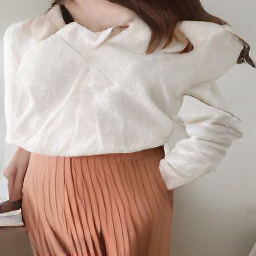

CPU times: user 38.7 ms, sys: 0 ns, total: 38.7 ms
Wall time: 40.2 ms


In [28]:
%%time
from torchvision.utils import make_grid, save_image
from PIL import Image

# https://github.com/lucidrains/DALLE-pytorch/blob/e1d10b9163ce78bacb5d8b42126255a0a8cdea35/generate.py#L93-L130
grid = make_grid(images, nrow=1, padding=0, pad_value=0)
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
im = Image.fromarray(ndarr)

print(input_text)
display(im)

In [26]:
!nvidia-smi

Sun Dec 26 06:49:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    39W / 250W |   9279MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------